In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.6 MB/s eta 0:00:00


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
import torch
from torch.optim.lr_scheduler import StepLR
import numpy as np
import torch.nn as nn
from sklearn.utils import resample
import torch.optim as optim
from collections import Counter
from torch_geometric.nn import SAGEConv, GINConv, GCNConv, GATConv, GAE
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, average_precision_score


# Load data
df = pd.read_csv("/content/train.txt", sep='\t', header=None, names=['Subject', 'Relation', 'Object'])
df.head()
df.drop_duplicates(inplace=True)

relation_counts = df['Relation'].value_counts()
print("Relation distribution in the training set:")
print(relation_counts)

Relation distribution in the training set:
Relation
/award/award_nominee/award_nominations./award/award_nomination/award_nominee                        15989
/film/film/release_date_s./film/film_regional_release_date/film_release_region                      12893
/award/award_nominee/award_nominations./award/award_nomination/award                                12157
/people/person/profession                                                                           10945
/film/actor/film./film/performance/film                                                              9494
                                                                                                    ...  
/user/alexander/philosophy/philosopher/interests                                                      100
/dataworld/gardening_hint/split_to                                                                     99
/film/special_film_performance_type/film_performance_type./film/performance/film                    

In [18]:
# Oversample the minority class
max_count = relation_counts.max()

# Oversample each class to the max_count
train_balanced = pd.concat([
    resample(df[df['Relation'] == relation],
             replace=True,  # Allow replacement
             n_samples=max_count,
             random_state=42)  # Seed for reproducibility
    for relation in relation_counts.index
])

# Shuffle the dataset
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
train_balanced.head()

,Subject,Relation,Object
0,/m/01dzz7,/influence/influence_node/influenced_by,/m/0gd_s
1,/m/02__7n,/award/award_winner/awards_won./award/award_ho...,/m/039bp
2,/m/0342h,/music/performance_role/regular_performances./...,/m/02jqjm
3,/m/089_x,/user/tsegaran/random/taxonomy_subject/entry./...,/m/04n6k
4,/m/045zr,/music/artist/origin,/m/018d5b


In [19]:
# Undersample the majority class
min_count = relation_counts.min()

train_balanced = pd.concat([
    df[df['Relation'] == relation].sample(n=min_count, random_state=42)
    for relation in relation_counts.index
])

# Shuffle the dataset
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
train_balanced.head()

,Subject,Relation,Object
0,/m/07cjqy,/base/popstra/celebrity/breakup./base/popstra/...,/m/04fzk
1,/m/04h1rz,/government/legislative_session/members./gover...,/m/070m6c
2,/m/01vsyjy,/music/group_member/membership./music/group_me...,/m/06w7v
3,/m/0853g,/base/biblioness/bibs_location/country,/m/0ctw_b
4,/m/03np_7,/education/educational_institution/students_gr...,/m/0_jm


In [20]:
df = train_balanced
# Split the data for training
train_temp, test = train_test_split(df, test_size=0.3, random_state=42)
train, val = train_test_split(train_temp, test_size=0.25, random_state=42)
# Optionally, reset indices for clarity
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

# Display the sizes of the datasets
print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")


Training set size: 4603
Validation set size: 1535
Test set size: 2631


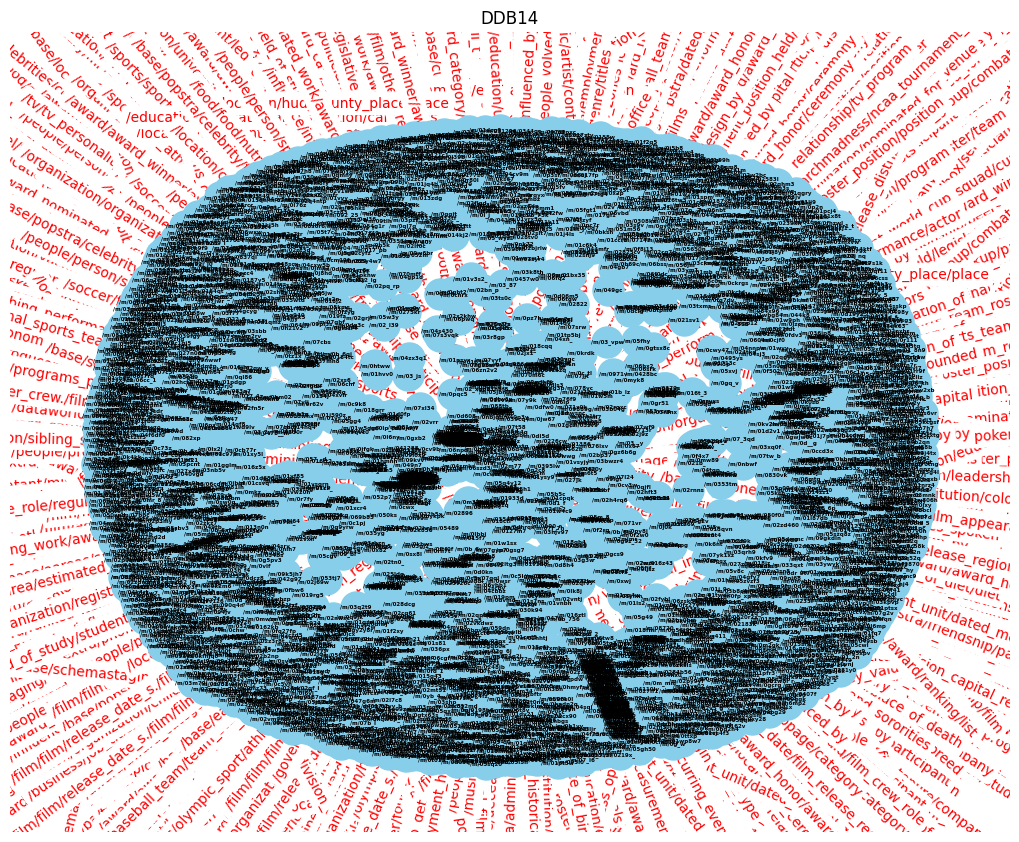

In [21]:
# Create a directed graph
D_Graph = nx.DiGraph()
for _, row in train.iterrows():
    D_Graph.add_edge(row['Subject'], row['Object'], label=row['Relation'])
# Visualization of the directed graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(D_Graph)  # Position nodes using the spring layout

# Draw the graph with labels and edge labels
nx.draw(D_Graph, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=4, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(D_Graph, 'label')

# Modify the way edge labels are drawn to handle potential path issues
for edge, label in edge_labels.items():
    try:
        nx.draw_networkx_edge_labels(D_Graph, pos, edge_labels={edge: label}, font_color='red')
    except ValueError:
        print(f"Skipping edge label for edge {edge} due to path issue.")

plt.title("FB15k-237")
plt.show()


In [22]:
# Map nodes to indices
node_to_index = {node: idx for idx, node in enumerate(D_Graph.nodes())}
train['Subject_idx'] = train['Subject'].map(node_to_index)
train['Object_idx'] = train['Object'].map(node_to_index)
train = train.dropna()
train['Subject_idx'] = train['Subject_idx'].astype(int)
train['Object_idx'] = train['Object_idx'].astype(int)

# Create edge index
edge_index = torch.tensor(train[['Subject_idx', 'Object_idx']].values, dtype=torch.long).t().contiguous()

# Create node features (initially as one-hot vectors)
num_nodes = len(node_to_index)
node_features = torch.eye(num_nodes)
train_data = Data(x=node_features, edge_index=edge_index)

# Visualization of the graph structure
# Convert to NetworkX graph for visualization
G = nx.DiGraph()

# Add nodes with their features (node_features are one-hot, so we use their indices)
for i in range(num_nodes):
    G.add_node(i)

# Add edges based on edge_index
edges = edge_index.t().tolist()  # Convert to list of edge tuples
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Position nodes using the spring layout


<Figure size 1000x800 with 0 Axes>

In [23]:
# Define the GSIN model by combining GraphSAGE and GIN
class GSIN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GSIN, self).__init__()
        self.sage_conv = SAGEConv(in_channels, hidden_channels)
        self.gin_conv = GINConv(nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        x = self.sage_conv(x, edge_index)
        x = torch.relu(x)
        x = self.gin_conv(x, edge_index)
        return x

In [24]:
def hits_k(preds, labels, k):
    total_relevant_items = 0
    relevant_at_k = 0

    for pred, true_labels in zip(preds, labels):
        # Convert PyTorch tensor to NumPy array if necessary
        if isinstance(pred, torch.Tensor):
            pred = pred.numpy()

        # Convert true_labels to a list if it's a scalar (0-d tensor)
        if isinstance(true_labels, torch.Tensor) and true_labels.dim() == 0:
            true_labels = [true_labels.item()]
        elif not isinstance(true_labels, (list, np.ndarray)):
            true_labels = [true_labels]

        # Get the indices of the top-k predictions
        top_k_indices = np.argsort(pred)[::-1][:k]

        # Count the number of relevant items in the top-k predictions
        relevant_at_k += len(set(top_k_indices) & set(true_labels))
        total_relevant_items += len(true_labels)

    # Calculate Recall@k
    recall_at_k = relevant_at_k / total_relevant_items if total_relevant_items > 0 else 0

    return recall_at_k


In [25]:
def mrr(edge_preds, labels):
    # Sort predictions in descending order
    sorted_indices = torch.argsort(edge_preds, descending=True)

    # Ensure labels are ordered according to sorted predictions
    sorted_labels = labels[sorted_indices]

    # Find the rank of the first correct prediction (label == 1)
    ranks = torch.where(sorted_labels == 1)[0]  # ranks are zero-indexed

    if len(ranks) == 0:
        return 0.0  # No correct prediction, return 0 MRR

    # Convert ranks to one-indexed (add 1)
    ranks = ranks + 1

    # Compute the reciprocal rank
    reciprocal_ranks = 1.0 / ranks.float()*100

    # Return the mean reciprocal rank
    return torch.mean(reciprocal_ranks).item()


In [26]:
# Define the link predictor model
class LinkPredictor(nn.Module):
    def __init__(self, in_channels):
        super(LinkPredictor, self).__init__()
        self.fc = nn.Linear(2 * in_channels, 1)

    def forward(self, x, edge_index):
        h_u = x[edge_index[0]]
        h_v = x[edge_index[1]]
        h_concat = torch.cat([h_u, h_v], dim=1)
        return self.fc(h_concat).squeeze()

hidden_channels = 64
out_channels = 128
model = GSIN(train_data.num_features, hidden_channels, out_channels)
link_predictor = LinkPredictor(out_channels)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
# Create positive and negative samples for training
def create_edge_labels(edge_index, num_nodes, num_neg_samples):
    pos_edge_index = edge_index
    pos_labels = torch.ones(pos_edge_index.size(1), dtype=torch.float)

    # Sample negative edges
    neg_edge_index = []
    while len(neg_edge_index) < num_neg_samples:
        i = torch.randint(0, num_nodes, (1,), dtype=torch.long).item()
        j = torch.randint(0, num_nodes, (1,), dtype=torch.long).item()
        if not ((i, j) in pos_edge_index.t().tolist() or (j, i) in pos_edge_index.t().tolist()):
            neg_edge_index.append([i, j])

    neg_edge_index = torch.tensor(neg_edge_index).t().contiguous()
    neg_labels = torch.zeros(neg_edge_index.size(1), dtype=torch.float)

    edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    return edge_index, labels

num_neg_samples = train_data.edge_index.size(1)  # Equal number of negative samples
edge_index, labels = create_edge_labels(train_data.edge_index, train_data.num_nodes, num_neg_samples)
link_predictor = LinkPredictor(out_channels)
criterion = nn.BCEWithLogitsLoss()

# Function to calculate Mean Rank (MR)
def mean_rank(edge_preds, labels):
    sorted_indices = torch.argsort(edge_preds, descending=True)
    ranks = torch.where(labels[sorted_indices] == 1)[0]

    if len(ranks) == 0:
        return float('inf')  # Return infinity if no positive samples

    mr = torch.mean(ranks.float()).item() + 1  # Mean Rank (MR), add 1 to start rank from 1

    total_possible_ranks = len(edge_preds)  # Total number of possible ranks
    total_possible_ranks
    mr_percentage = (mr / total_possible_ranks) * 100  # Convert MR to percentage

    return mr_percentage

# Function to calculate Mean Average Precision (MAP)
def mean_average_precision(edge_preds, labels):
    sorted_indices = torch.argsort(edge_preds, descending=True)
    sorted_labels = labels[sorted_indices]
    precisions = []
    num_positives = 0
    for i, label in enumerate(sorted_labels):
        if label == 1:
            num_positives += 1
            precisions.append(num_positives / (i + 1))
    if num_positives == 0:
        return 0.0
    return torch.mean(torch.tensor(precisions)).item()

def create_val_edge_labels(val_pos_edge_index, num_nodes, num_neg_samples):
    # Positive samples from validation set
    pos_labels = torch.ones(val_pos_edge_index.size(1), dtype=torch.float)

    # Sample negative edges ensuring they are not in the positive edge set
    neg_edge_index = []
    while len(neg_edge_index) < num_neg_samples:
        i = torch.randint(0, num_nodes, (1,), dtype=torch.long).item()

        j = torch.randint(0, num_nodes, (1,), dtype=torch.long).item()
        if not ((i, j) in val_pos_edge_index.t().tolist() or (j, i) in val_pos_edge_index.t().tolist()):
            neg_edge_index.append([i, j])

    neg_edge_index = torch.tensor(neg_edge_index).t().contiguous()
    neg_labels = torch.zeros(neg_edge_index.size(1), dtype=torch.float)

    val_edge_index = torch.cat([val_pos_edge_index, neg_edge_index], dim=1)
    val_labels = torch.cat([pos_labels, neg_labels], dim=0)

    return val_edge_index, val_labels

In [27]:
hidden_channels = 64
out_channels = 128
model = GSIN(train_data.num_features, hidden_channels, out_channels)
#encoder = Encoder(train_data.num_features, hidden_channels)
#model = GAE(encoder)
link_predictor = LinkPredictor(out_channels)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
k = 10
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {'mrr': [], 'mr': [], 'map': [], 'auc': [], 'hits': []}

for train_index, val_index in kf.split(df):
  # Define the GSIN model
  optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
  # Train the GSIN model
  model.train()
  link_predictor.train()
  for epoch in range(60):
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    edge_preds = link_predictor(out, edge_index)
    #z = model.encode(train_data.x, train_data.edge_index)
    #edge_preds = link_predictor(z, edge_index)
    loss = criterion(edge_preds, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()



    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


  # Validation
  val['Subject_idx'] = val['Subject'].map(node_to_index)
  val['Object_idx'] = val['Object'].map(node_to_index)
  val = val.dropna()

  val['Subject_idx'] = val['Subject_idx'].astype(int)
  val['Object_idx'] = val['Object_idx'].astype(int)
  val_pos_edge_index = torch.tensor(val[['Subject_idx', 'Object_idx']].values.T, dtype=torch.long)
  val_edge_index, val_labels = create_val_edge_labels(val_pos_edge_index, num_nodes, num_neg_samples)

  model.eval()
  link_predictor.eval()
  with torch.no_grad():
    val_out = model(train_data.x, train_data.edge_index)
    val_edge_preds = link_predictor(val_out, val_edge_index)
    #z = model.encode(train_data.x, train_data.edge_index)
    #val_edge_preds = link_predictor(z, val_edge_index)
    val_edge_preds = torch.sigmoid(val_edge_preds)
    val_hits = hits_k(val_edge_preds, val_labels, k)
    val_mrr = mrr(val_edge_preds, val_labels)
    val_auc = roc_auc_score(val_labels.numpy(), torch.sigmoid(val_edge_preds).numpy())
    val_map = mean_average_precision(val_edge_preds, val_labels)
    val_mr = mean_rank(val_edge_preds, val_labels)


  results['hits'].append(val_hits)
  results['mrr'].append(val_mrr)
  results['mr'].append(val_mr)
  results['map'].append(val_map)
  results['auc'].append(val_auc)

# Average results across folds
#avg_hits = torch.tensor(results['hits']).mean().item()
avg_mrr = torch.tensor(results['mrr']).mean().item()
avg_mr = torch.tensor(results['mr']).mean().item()
avg_map = torch.tensor(results['map']).mean().item()
avg_auc = torch.tensor(results['auc']).mean().item()

# Print average results
print(f"Average Hits@{k}: {val_hits}")
print(f"Average MRR: {val_mrr}")
print(f"Average MR: {avg_mr}")
print(f"Average MAP: {avg_map}")
print(f"Validation AUC: {avg_auc}")


# Extract node embeddings
#node_embeddings = model(train_data.x, train_data.edge_index).detach().numpy()


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0, Loss: 0.6978442072868347
Epoch 20, Loss: 0.2786480784416199
Epoch 40, Loss: 0.11006981134414673


<ipython-input-27-fc33d2658324>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Subject_idx'] = val['Subject_idx'].astype(int)
<ipython-input-27-fc33d2658324>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Object_idx'] = val['Object_idx'].astype(int)


Epoch 0, Loss: 0.10649669170379639
Epoch 20, Loss: 0.08892437815666199
Epoch 40, Loss: 0.0713861882686615
Epoch 0, Loss: 0.14203089475631714
Epoch 20, Loss: 0.10360076278448105
Epoch 40, Loss: 0.07341890037059784
Epoch 0, Loss: 0.09364182502031326
Epoch 20, Loss: 0.09179829061031342
Epoch 40, Loss: 0.23985208570957184
Epoch 0, Loss: 0.26648610830307007
Epoch 20, Loss: 0.12544752657413483
Epoch 40, Loss: 0.4515271782875061
Average Hits@10: 0.8789383234676341
Average MRR: 0.9098238348960876
Average MR: 29.59029769897461
Average MAP: 0.41041502356529236
Validation AUC: 0.7322610202782303
